In [7]:
# Load modules
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter
import math

from torchsummary import summary

from Dataset_Maker_Lines_and_Juncs import make_random_line_set, make_grey_transform_lines, make_random_junction_set, make_grey_transform_junc
from multijunction import MultiJunction

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(
            0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [25]:
# Load dataset 

data_folder = 'foj_data/grayscale_junctions/'


# Start with purely junction images
# with open(data_folder + 'junction_data_24_10000_grey_multicolor_noiseless_centered.pkl','rb') as f:
# with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_centered.pkl','rb') as f:
with open(data_folder + 'junction_data_24_30000_grey_multicolor_noiseless_center_range_2.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

In [26]:
# Create data structure with optional transforms

# class JunctionDataset(torch.utils.data.Dataset):
#     """ Dataset with support of transforms.
#     """

#     def __init__(self, images, params, boundaries, transform=None):
#         self.images = images
#         self.params = params
#         self.boundaries = boundaries
#         self.transform = transform

#     def __getitem__(self, index):
#         image = self.images[index]

#         if self.transform:
#             image = self.transform(image)
            
#         param = self.params[index,:]
#         boundary = boundaries[index]

#         return image, param, boundary

#     def __len__(self):
#         return len(self.images)

class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)
            
        # Data generated as: theta1, theta2, theta3, u, v
        # We want representation: alpha [orientation], omega1, omega2, omega3, u, v

        jparam = self.params[index].squeeze()
        center = jparam[3:]
        angles_ord = torch.sort(jparam[:3])[0]
        
#         print(angles_ord)

        omega1 = angles_ord[1]-angles_ord[0]
        omega2 = angles_ord[2]-angles_ord[1]
        omega3 = 2*torch.pi - omega1 - omega2
        
        angles = torch.tensor([angles_ord[0], omega1, omega2, omega3])
        
        jparam_out = torch.cat((angles,center))

        boundary = boundaries[index]

        return image, jparam_out, boundary

    def __len__(self):
        return len(self.images)
    
    
# Make training and testing data
junc_data = JunctionDataset(wedges_grey, params, boundaries)#, transform=trainTransform)
data_size = len(junc_data)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junc_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


# print(next(iter(train_loader)))


tensor([ 1.2137,  1.3745,  2.9188,  1.9899, -0.5496, -0.7275])


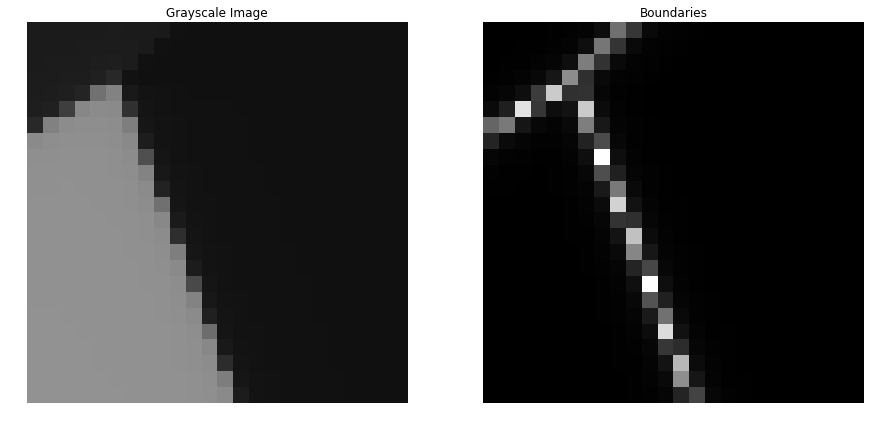

In [27]:
data = next(iter(test_loader))
wedge_image = data[0]
boundary_image = data[2]

print(data[1][0])


img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(121)
plt.imshow(wedge_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(122)
plt.imshow(boundary_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');



In [28]:
# Make Transformation matrix L

# Assume output of first network is 24 x 24
Wn,Hn = 24,24

# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device=dev),torch.zeros((Wn,Hn),device=dev)

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0, 1.0, Wn, device=dev),
                               torch.linspace(-1.0, 1.0, Hn, device=dev)])

L = torch.zeros((1,3,3,Hn,Wn),device=dev)
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya


Linv = torch.zeros_like(L)
for ii in range(L.shape[3]):
    for jj in range(L.shape[4]):
        Linv[0,:,:,ii,jj] = torch.inverse(L[0,:,:,ii,jj])

# L transforms line parameters for patches into the global coordinate system
# Linv transforms global line parameters into patch line parameters

tensor([[ 1.6494,  1.5644,  1.1776,  3.5411, -1.6970, -1.8202],
        [ 0.0701,  4.6904,  0.5092,  1.0836, -0.1857, -0.8071],
        [ 0.4174,  0.0859,  4.2721,  1.9252, -0.8790, -0.2806],
        ...,
        [ 3.8368,  0.3670,  1.1805,  4.7357, -1.5841, -0.6323],
        [ 0.3067,  2.5880,  0.7576,  2.9376, -0.1508, -1.8707],
        [ 0.4868,  0.0797,  3.7222,  2.4813, -1.7764, -1.2925]],
       device='cuda:0')


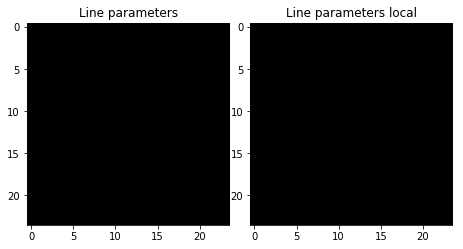

/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/numpy/ma/core.py:717: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, 

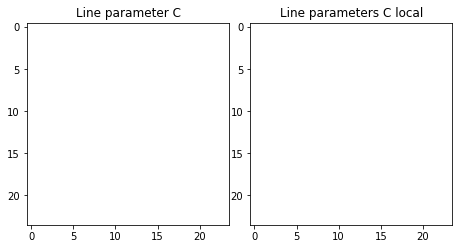

In [76]:
# Given a set of line parameters, construct the ground truth:
def make_ground_truth(params,Linv,H,rf,x0,y0):
    
#         theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        
        theta1 = params[:,0]
        theta2 = params[:,0] + params[:,1]
        theta3 = params[:,0] + params[:,1] + params[:,2]
        
        theta = torch.stack((theta1,theta2,theta3),axis=1).unsqueeze(2).unsqueeze(3)
        cx = params[:,4]
        cy = params[:,5]
        
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # radius threshold 
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        full_mask = mask1*mask2
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        global_line_params = torch.stack((a,b,c),dim=4)
        
        ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
        return ground_truth_global,ground_truth_local
    

data = next(iter(train_loader))
gt_line_params = data[1].to(dev)

print(gt_line_params)

gt, gt_local = make_ground_truth(gt_line_params[0,:].squeeze().unsqueeze(0),Linv,24,10,x0,y0)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0].cpu()))
plt.title('Line parameters')
plt.subplot(222)
plt.imshow(torch.abs(gt_local[0].cpu()))
plt.title('Line parameters local')
plt.subplots_adjust(wspace=0, hspace=.15)

# For visualization purposes:
# Slopes (a/b) are the same, but c is different for local vs global
# SANITY CHECK: c is zero because all the lines go through the center

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0,:,:,2].cpu()))
plt.title('Line parameter C')
plt.subplot(222)
plt.imshow(torch.abs(gt_local[0,:,:,2].cpu()))
plt.title('Line parameters C local')
plt.subplots_adjust(wspace=0, hspace=.15)

In [86]:
def make_ground_truth(params,Linv,H,rf,x0,y0):
    
#         theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        
        theta1 = params[:,0]
        theta2 = params[:,0] + params[:,1]
        theta3 = params[:,0] + params[:,1] + params[:,2]
        
        theta = torch.stack((theta1,theta2,theta3),axis=1).unsqueeze(2).unsqueeze(3)
        
        
        cx = params[:,4]
        cy = params[:,5]
        
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # radius threshold 
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)

        
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        full_mask = mask1*mask2
        full_mask = full_mask/torch.maximum(torch.tensor(1e-5,device=dev),torch.max(full_mask.view(params.shape[0],-1,3),1)[0]).unsqueeze(2).unsqueeze(3)

        global_line_params = torch.stack((a,b,c),dim=4)
        
        ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
        return ground_truth_global,ground_truth_local
    

bad_params = torch.tensor([1.6494,  1.5644,  1.1776,  3.5411, -1.6970, -1.8202],device=dev)

gt, gt_local = make_ground_truth(bad_params.squeeze().unsqueeze(0),Linv,24,10,x0,y0)

print(gt)

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], device='cuda:0')


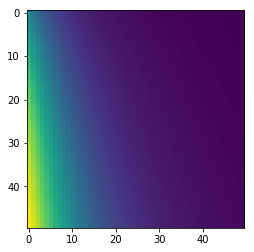

In [87]:
opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .2   # Dirac delta relaxation parameter for rendering boundary maps


b_gt = MultiJunction(3, dev, gt_line_params[:,4:], gt_line_params[:,0], gt_line_params[:,1:4]).render_boundaries(opts,dev).to(dev) 

plt.figure()
plt.imshow(b_gt.cpu()[0])



In [88]:
# Predict sin & cos of 3 lines

class lineToJunctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3)
#         self.conv3 = nn.Conv2d(6, 6, kernel_size=3)
        self.fc1 = nn.LazyLinear(8)
        self.fc2 = nn.LazyLinear(8)
        self.activate = nn.ReLU()
        self.tanH = nn.Tanh()
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = self.conv3(x)
#         x = self.activate(x)
#         print(x.shape)
        x = x.reshape(x.shape[0],-1)
#         print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)

        # The network will output 8 values:
        # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v

#       First, use sigmoid to ensure first 6 outputs lie between -1 and 1
        x_norm = self.tanH(x[:,:6])
        
#       Next, normalize s/c(theta1), s/c(theta2), s/c(theta3)
        
        theta1_norm = torch.norm(x_norm[:,:2],dim=1).unsqueeze(1)
        theta2_norm = torch.norm(x_norm[:,2:4],dim=1).unsqueeze(1)
        theta3_norm = torch.norm(x_norm[:,4:6],dim=1).unsqueeze(1)

        out1 = x_norm[:,:2]/theta1_norm
        out2 = x_norm[:,2:4]/theta2_norm
        out3 = x_norm[:,4:6]/theta3_norm
        
        out = torch.cat((out1,out2,out3,x[:,6:]),dim=1)

        return out
    
R = 24

junction_model = lineToJunctionNet()
junction_model = junction_model.to(dev)
summary(junction_model, input_size=(3, R, R))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 22, 22]             168
              ReLU-2            [-1, 6, 22, 22]               0
            Conv2d-3            [-1, 1, 20, 20]              55
              ReLU-4            [-1, 1, 20, 20]               0
            Linear-5                    [-1, 8]           3,208
            Linear-6                    [-1, 8]              72
              Tanh-7                    [-1, 6]               0
Total params: 3,503
Trainable params: 3,503
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [89]:
# Predict sin & cos of 3 lines

class lineToJunctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(3, 3, kernel_size=3)
        self.conv3 = nn.Conv2d(3, 1, kernel_size=3)
        self.fc1 = nn.LazyLinear(8)
        self.activate = nn.ReLU()
        self.tanH = nn.Tanh()
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)

        # The network will output 8 values:
        # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v

#       First, use sigmoid to ensure first 6 outputs lie between -1 and 1
        x_norm = self.tanH(x[:,:6])
        
#       Next, normalize s/c(theta1), s/c(theta2), s/c(theta3)
        
        theta1_norm = torch.norm(x_norm[:,:2],dim=1).unsqueeze(1)
        theta2_norm = torch.norm(x_norm[:,2:4],dim=1).unsqueeze(1)
        theta3_norm = torch.norm(x_norm[:,4:6],dim=1).unsqueeze(1)

        out1 = x_norm[:,:2]/theta1_norm
        out2 = x_norm[:,2:4]/theta2_norm
        out3 = x_norm[:,4:6]/theta3_norm
        
        out = torch.cat((out1,out2,out3,x[:,6:]),dim=1)

        return out
    
R = 24

junction_model = lineToJunctionNet()
junction_model = junction_model.to(dev)
summary(junction_model, input_size=(3, R, R))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 22, 22]              84
              ReLU-2            [-1, 3, 22, 22]               0
            Conv2d-3            [-1, 3, 20, 20]              84
              ReLU-4            [-1, 3, 20, 20]               0
            Conv2d-5            [-1, 1, 18, 18]              28
            Linear-6                    [-1, 8]           2,600
              Tanh-7                    [-1, 6]               0
Total params: 2,796
Trainable params: 2,796
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [93]:
# Now let's train the initial network 

model = lineToJunctionNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.02) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .2   # Dirac delta relaxation parameter for rendering boundary maps


def boundary_loss(output_line_params, output_gt, opts, dev):
        
        # First deal with ground truth, which is represented as M-junctions
        b_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4]).render_boundaries(opts,dev).to(dev) 

        # Next deal with the output of the network
        # Convert output into format accepted by MultiJunction
        angles,_ = torch.sort(torch.stack((torch.atan2(output_line_params[:,1],output_line_params[:,0]),\
                               torch.atan2(output_line_params[:,3],output_line_params[:,2]),\
                              torch.atan2(output_line_params[:,5],output_line_params[:,4])),axis=1),axis=1)
        
        alpha_out = angles[:,0]
        omega1_out = angles[:,1] - alpha_out
        omega2_out = angles[:,2] - omega1_out
        omega3_out = 2*torch.pi - omega1_out - omega2_out
        omega_all_out = torch.cat((omega1_out.unsqueeze(1),omega2_out.unsqueeze(1),omega3_out.unsqueeze(1)),dim=1)
        
        jn = MultiJunction(3, dev, output_line_params[:,6:], alpha_out, omega_all_out)
#         jn = MultiJunction(3, dev, torch.zeros((output_line_params.shape[0],2),device=dev), alpha_out, omega_all_out)
        b = jn.render_boundaries(opts,dev)
            
        loss = mse_loss(b,b_gt) + .01*torch.mean(torch.norm(output_line_params[:,6:],dim=1))
    
        return loss, b, b_gt
    
    
def cross_entropy_loss(output_line_params, output_gt, opts):
            
        # Calculate the ground truth angles
#         angles = torch.round(torch.rad2deg(output_gt[:,:3]))
#         angles = (angles + 360) % 360

        # Convert to a one hot encoding
        angles_gt_oh = F.one_hot(angles[:,0].long(), num_classes=360) \
            + F.one_hot(angles[:,1].long(), num_classes=360) \
            + F.one_hot(angles[:,2].long(), num_classes=360)
        
#         loss = bce_loss(output_line_params,angles_gt_oh.double())
        loss = mlsm_loss(output_line_params,angles_gt_oh.double())
    
        return loss, angles_gt_oh

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

    # Interpret inputs as their ground truth
    gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
    new_inputs = gt.permute(0,3,1,2)
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss,_,_ = boundary_loss(output_line_params,output_gt, opts, dev)
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)

    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 20:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 1.7943495681472854, Avg. Test Loss: 0.2953205704689026
Epoch: 2, Avg. Train Loss: 0.2081354482501161, Avg. Test Loss: 0.24586121737957
Epoch: 3, Avg. Train Loss: 0.18380248195984783, Avg. Test Loss: 0.18274183571338654
Epoch: 4, Avg. Train Loss: 0.14815923542368645, Avg. Test Loss: 0.1593129187822342
Epoch: 5, Avg. Train Loss: 0.13434442001230576, Avg. Test Loss: 0.14878065884113312
Epoch: 6, Avg. Train Loss: 0.126597431798776, Avg. Test Loss: 0.13873910903930664
Epoch: 7, Avg. Train Loss: 0.12050884567639407, Avg. Test Loss: 0.1394302248954773
Epoch: 8, Avg. Train Loss: 0.11914686332730685, Avg. Test Loss: 0.1273173838853836
Epoch: 9, Avg. Train Loss: 0.1118189324350918, Avg. Test Loss: 0.1211576983332634
Epoch: 10, Avg. Train Loss: 0.10976967405454785, Avg. Test Loss: 0.12449894845485687
Epoch: 11, Avg. Train Loss: 0.20698947181888655, Avg. Test Loss: 0.197801873087883
Epoch: 12, Avg. Train Loss: 0.16858293729669907, Avg. Test Loss: 0.16469857096672058
Epoc

KeyboardInterrupt: 

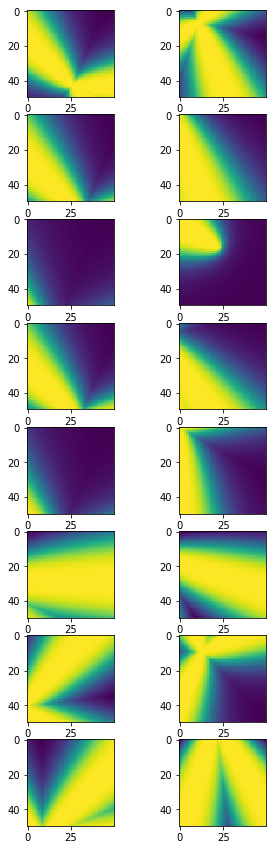

In [94]:
# Visualize the output of the network for boundary loss

data = next(iter(test_loader))

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)

gt_line_params = data[1].to(dev)

# print(output_line_params[0])

# print(output_line_params[:5,:])

loss, b, b_gt = boundary_loss(output_line_params, gt_line_params, opts, dev)

plt.figure(figsize=[5,15])

num_plot = 8


for ii in range(num_plot):
    
    plt.subplot(num_plot,2,2*ii+1)
    plt.imshow(b[ii].cpu().detach())
    plt.subplot(num_plot,2,2*ii+2)
    plt.imshow(b_gt[ii].cpu())

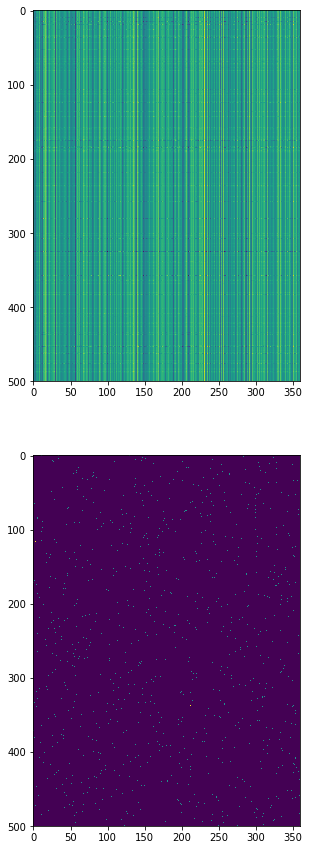

In [130]:
# Visualize the output of the network for cross entropy loss

data = next(iter(test_loader))

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .05   # Dirac delta relaxation parameter for rendering boundary maps

# Find output of the network 
output_line_params,output_loss,angles_gt_oh = forward_pass(data, opts, training = 0)

plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(output_line_params.cpu().detach())
plt.subplot(212)
plt.imshow(angles_gt_oh.cpu().detach().squeeze())

# gt_line_params = data[1].to(dev)

# print(output_line_params[0])

# # print(output_line_params[:5,:])

# b, b_gt,_ = boundary_loss(output_line_params, gt_line_params, opts)

# # print(b.shape,b_gt.shape)

# plt.figure(figsize=[5,15])

# num_plot = 8

# for ii in range(num_plot):
    
#     plt.subplot(num_plot,2,2*ii+1)
#     plt.imshow(b[ii].cpu().detach())
#     plt.subplot(num_plot,2,2*ii+2)
#     plt.imshow(b_gt[ii].cpu())

In [ ]:
# def network_loss(output_line_params, output_gt, opts):

    
# #         jn_gt = jn_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4])
# #         b_gt = jn_gt.render_boundaries(opts).to(dev)
        
#         # Convert gt into output format:
#         # Gt junction parameters:
#         # alpha, omega1, omega2, omega3, u, v
#         # c(theta1), s(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
#         # c(theta1) = torch.cos(alpha)
#         # s(theta1) = torch.sin(alpha)
#         # c(theta2) = torch.cos(alpha + omega1)
#         # s(theta2) = torch.sin(alpha + omega1)
#         # c(theta3) = torch.cos(alpha + omega1 + omega2)
#         # s(theta2) = torch.sin(alpha + omega1 + omega2)
        
#         ct1 = torch.cos(output_gt[:,0]).unsqueeze(1)
#         st1 = torch.sin(output_gt[:,0]).unsqueeze(1)
#         ct2 = torch.cos(output_gt[:,0] + output_gt[:,1]).unsqueeze(1)
#         st2 = torch.sin(output_gt[:,0] + output_gt[:,1]).unsqueeze(1)
#         ct3 = torch.cos(output_gt[:,0] + output_gt[:,2]).unsqueeze(1)
#         st3 = torch.sin(output_gt[:,0] + output_gt[:,2]).unsqueeze(1)
#         u = output_gt[:,4].unsqueeze(1)
#         v = output_gt[:,5].unsqueeze(1)
        
#         gt_reformat = torch.cat((ct1,st1,ct2,st2,ct3,st3,u,v),dim=1)
        
#         loss = mse_loss(output_line_params,gt_reformat)
#         # Output junction parameters:
#         # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
#         # Convert to:
#         # alpha, omega1, omega2, omega3, u, v
        
#         # alpha = atan2(s(theta1),c(theta1))
#         # omega1 = atan2(s(theta2),c(theta2)) - alpha
#         # omega2 = atan2(s(theta3),c(theta3)) - omega1
#         # omega3 = 2*pi - omega1 - omega2
        
# #         print(output_line_params.shape)
        
# #         alpha_out = torch.atan2(output_line_params[:,1],output_line_params[:,0])
# #         omega1_out = torch.atan2(output_line_params[:,3],output_line_params[:,2]) - alpha_out
# #         omega2_out = torch.atan2(output_line_params[:,5],output_line_params[:,4]) - omega1_out
# #         omega3_out = 2*torch.pi - omega1_out - omega2_out
        
# #         omega_all_out = torch.cat((omega1_out.unsqueeze(1),omega2_out.unsqueeze(1),omega3_out.unsqueeze(1)),dim=1)
        
# #         jn = MultiJunction(3, dev, output_line_params[:,6:], alpha_out, output_line_params[:,2:5])
# #         jn = MultiJunction(3, dev, torch.zeros((output_line_params.shape[0],2),device=dev), alpha_out, omega_all_out)
# #         b = jn.render_boundaries(opts)
                
# #         loss = mse_loss(b,b_gt) #+ .1*torch.mean(torch.norm(output_line_params[:,5:],dim=1))
    
#         return b, b_gt, loss


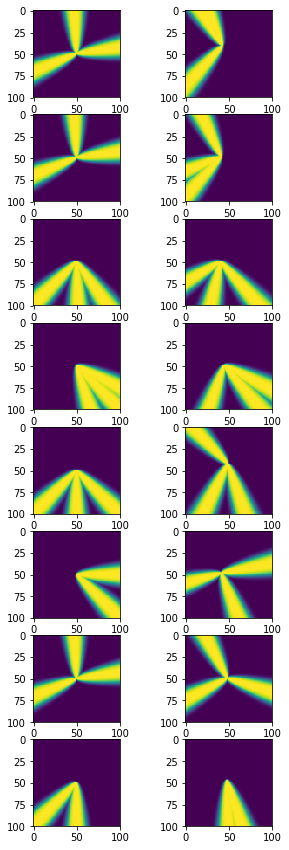

In [585]:
data = next(iter(test_loader))

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)

gt_line_params = data[1].to(dev)

# print(output_line_params[:5,:])

b, b_gt,_ = network_loss(output_line_params, gt_line_params, opts)

# print(b.shape,b_gt.shape)

plt.figure(figsize=[5,15])

num_plot = 8

for ii in range(num_plot):
    
    plt.subplot(num_plot,2,2*ii+1)
    plt.imshow(b[ii].cpu().detach())
    plt.subplot(num_plot,2,2*ii+2)
    plt.imshow(b_gt[ii].cpu())

In [ ]:
# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 4

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)

low_var = running_var.squeeze()<100
low_var_2 = running_var_2.squeeze()<100

plt.imshow(low_var)
plt.subplot(122)
plt.imshow(low_var_2)
# plt.colorbar()

# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))

